In [1]:
import datetime as dt

In [2]:
import numpy as np

In [18]:
import yfinance as yf
from yahoofinancials import YahooFinancials

In [4]:
import matplotlib.pyplot as plt  
import pandas as pd  
#from util import get_data, plot_data

In [5]:
import scipy.optimize as spo
import matplotlib.dates as mdates

In [40]:
def stocks_price(stocks, start_date, end_date):
    dates = pd . date_range ( start_date , end_date )
    df_merged = pd.DataFrame (index = dates) 
    for stock in stocks:
        df_temp = yf.download(stock , start=start_date, end=end_date, progress=False)
        df_temp = df_temp. rename ( columns ={'Adj Close':stock})
        df_temp = df_temp.loc [:, stock]
        df_merged = df_merged.join(df_temp , how ='inner')
    return df_merged

In [25]:
def _neg_sharpe_ratio(allocs, df):
    df = df.multiply(allocs)
    df = df.sum(axis=1)
    df = (df/df.shift(1))  - 1 # find daily returns
    df = df.iloc[1:] # remove first row
    df_mean = df.mean()
    df_std = df.std()
    neg_sharpe_ratio = -1*np.sqrt(252)*df_mean/df_std
    return neg_sharpe_ratio

In [19]:
sd=dt.datetime(2008, 1, 1)  
ed=dt.datetime(2009, 1, 1) 
dates = pd . date_range ( sd , ed )

In [58]:

def optimize_portfolio(
    sd=dt.datetime(2008, 1, 1),  
    ed=dt.datetime(2009, 1, 1),  
    syms=["SPY","GOOG", "AAPL", "GLD", "XOM"], 
    gen_plot=False):
    """  
    This function should find the optimal allocations for a given set of stocks based on maximum Sharpe    
    Ratio. The function accept as input a list of symbols as well as start and end dates and return a list of 
    floats (as a one-dimensional numpy array) that represents the allocations to each of the equities.  
    :param sd: A datetime object that represents the start date, defaults   
    :type sd: datetime  
    :param ed: A datetime object that represents the end date, defaults  
    :type ed: datetime  
    :param syms: A list of symbols that make up the portfolio 
    :type syms: list 
    :param gen_plot: If True, optionally create a plot named plot.png. 
    :type gen_plot: bool  
    :return: A tuple containing the portfolio allocations, cumulative return, average daily returns,  
        standard deviation of daily returns, and Sharpe ratio 
    :rtype: tuple 
    """  
 
    # Read in adjusted closing prices for given symbols, date range  
    dates = pd.date_range(sd, ed)  
    
    prices_all = stocks_price(syms, sd, ed)
    
    # Filling missing values (if any)
    prices_all.fillna(method ='ffill',inplace=True)
    prices_all.fillna(method ='bfill',inplace=True)
    #
    prices = prices_all[syms]  # only portfolio symbols 
    prices_SPY = prices_all["SPY"]  # only SPY, for comparison later

    #prices_SPY = normalize_stocks(prices_SPY)
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later


    normed = prices / prices.iloc[0] # find normalized prices

    stock_count = len(syms)
    allocs = [1.0 / stock_count for i in syms]
    bounds = tuple((0.0, 1.0) for i in syms)




    stock_numbers = len(syms)
    
    # set starting value for allocation
    allocs = [1.0 / stock_numbers for i in syms] # set equal allocation for each stock
    # bound for each allocation
    bounds = tuple((0.0, 1.0) for i in range(stock_numbers)) # allocation bounds for each stock (0,1)

    df = normed.copy()

    # check allocation sums to 1
    def _check_sum(allocs):
        return np.sum(allocs) - 1

    # constraints variable:
    constraints = ({'type': 'eq', 'fun':_check_sum})

    '''minimizing the _neg_sharpe_ratio function with respect to differenct alloc values 
    while the df is treated as argument (not changed), the Sequential Least Squares Programming \
    method is used for optimization'''
    
    min_result = spo.minimize(_neg_sharpe_ratio, allocs,args=df,method='SLSQP',bounds=bounds,
                              constraints=constraints,options={'disp': False},)


    #optimized results:
    sharpe_ratio = min_result.fun  # optimised sharpe ratio
    allocs = min_result.x  # optimised allocs

    # Get daily portfolio value 
    #port_val = prices_SPY  # add code here to compute daily portfolio values


    prices_SPY = prices_SPY / prices_SPY.iloc[0] # normalised SPY

    port_val = normed.multiply(allocs)
    port_val = port_val.sum(axis=1)
    daily_returns = (port_val / port_val.shift(1)) - 1
    daily_returns = daily_returns[1:]

    # calculating return values:
    cr = port_val[-1] / port_val[0] - 1
    sr = -sharpe_ratio
    sddr = daily_returns.std()
    adr = daily_returns.mean()



    # Compare daily portfolio value with SPY using a normalized plot  
    if gen_plot:  
        # add code to plot here  
        df_temp = pd.concat(  [port_val, prices_SPY], keys=["Optimal Portfolio", "SPY"], axis=1)
        ax = df_temp.plot()
        plt.ylabel('Normalized Value')
        plt.xlabel('Date')
        plt.title('Daily Optimal Portfolio Value vs SPY', fontsize=12)
        date_form = mdates.DateFormatter('%b-%Y')
        ax.xaxis.set_major_formatter(date_form)
        plt.grid(axis="x")
        plt.grid(axis="y")
        plt.savefig('plot')



    return (allocs, cr, adr, sddr, sr)

Start Date: 2020-06-01 00:00:00
End Date: 2022-06-01 00:00:00
Symbols: ['SPY', 'HAL', 'SLB', 'MSFT']
Allocations:[2.81892565e-18 4.40195356e-01 1.68030090e-17 5.59804644e-01]
Sharpe Ratio: 1.5755712374523851
Volatility (stdev of daily returns): 0.019044087631547236
Average Daily Return: 0.0018901572866596619
Cumulative Return: 1.3637188304132657


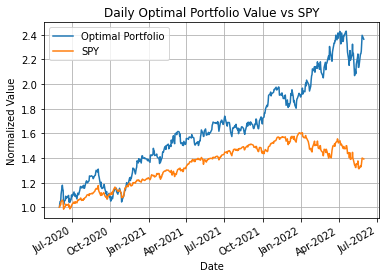

In [60]:
start_date = dt.datetime(2020, 6, 1)
end_date = dt.datetime(2022, 6, 1)
symbols = ['SPY','HAL', 'SLB', 'MSFT']

# Assess the portfolio  
(allocations, cr, adr, sddr, sr) = optimize_portfolio(
        sd=start_date, ed=end_date, syms=symbols, gen_plot=True) 

# Print statistics  
print(f"Start Date: {start_date}")  
print(f"End Date: {end_date}")  
print(f"Symbols: {symbols}")  
print(f"Allocations:{allocations}") 
print(f"Sharpe Ratio: {sr}")  
print(f"Volatility (stdev of daily returns): {sddr}") 
print(f"Average Daily Return: {adr}")  
print(f"Cumulative Return: {cr}") 